## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

In [190]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Прочитаем наш файл с исходными данными:

In [191]:
taxi_data = pd.read_csv("/content/gdrive/MyDrive/Practice/train.csv")
print('Форма тренировочных данных: {}'.format(taxi_data.shape))
taxi_data.head()

Форма тренировочных данных: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [192]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print(taxi_data['pickup_datetime'].min())
print(taxi_data['pickup_datetime'].max())

2016-01-01 00:00:17
2016-06-30 23:59:39


### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [193]:
taxi_data.isnull().sum().sum()

0

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [194]:
median_trip_duration = taxi_data['trip_duration'].median()

print('Уникальных таксопарков: ', taxi_data['vendor_id'].nunique())
print('Максимальное количество пассажиров: ', taxi_data['passenger_count'].max())
print('Средняя длительность поездки (в секундах): ', round(taxi_data['trip_duration'].mean()))
print('Медианная длительность поездки (в секундах): ', round(median_trip_duration))
print('Минимальная длительность поездки (в секундах): ', round(taxi_data['trip_duration'].min()))
print('Максимальная длительность поездки (в секундах): ', round(taxi_data['trip_duration'].max()))

Уникальных таксопарков:  2
Максимальное количество пассажиров:  9
Средняя длительность поездки (в секундах):  959
Медианная длительность поездки (в секундах):  662
Минимальная длительность поездки (в секундах):  1
Максимальная длительность поездки (в секундах):  3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [195]:
def add_datetime_features(dataframe):
    # Преобразуем столбец 'pickup_datetime' в формат datetime и извлекаем дату
    dataframe['pickup_date'] = pd.to_datetime(dataframe['pickup_datetime'], format='%Y-%m-%d').dt.date

    # Извлекаем час из 'pickup_datetime'
    dataframe['pickup_hour'] = dataframe['pickup_datetime'].dt.hour

    # Извлекаем день недели из 'pickup_datetime'
    dataframe['pickup_day_of_week'] = dataframe['pickup_datetime'].dt.day_name()
    return dataframe

# Добавляем новые признаки, связанные с датой и временем
add_datetime_info(taxi_data)

# Выводим количество поездок, сделанных в субботу
print('Количество поездок в субботу: ', taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday'].shape[0])

# Выводим среднее количество поездок в день
print('Среднее количество поездок в день: ', round(taxi_data.groupby('pickup_date').size().mean()))


Количество поездок в субботу:  220868
Среднее количество поездок в день:  8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [196]:
# Загрузка данных о праздниках
holiday_data = pd.read_csv('/content/gdrive/MyDrive/Practice/holiday_data.csv', sep=';')

def add_holiday_features(taxi_data, holiday_data):
    # Преобразуем дату начала поездки и дату праздника в формат datetime
    taxi_data['pickup_datetime'], holiday_data['date'] = pd.to_datetime(taxi_data['pickup_datetime']).dt.date, pd.to_datetime(holiday_data['date']).dt.date

    # Инициализируем столбец 'pickup_holiday' нулями
    taxi_data['pickup_holiday'] = 0

    # Помечаем поездки, которые начались в праздничный день
    taxi_data.loc[taxi_data['pickup_datetime'].isin(holiday_data['date']), 'pickup_holiday'] = 1

    return taxi_data

# Применяем функцию add_holiday_features() к данных о поездках
taxi_data = add_holiday_features(taxi_data, holiday_data)


In [197]:
# Отбираем поездки, которые начались в день праздника
holiday_trips = taxi_data[taxi_data['pickup_holiday'] == 1]

# Вычисляем и выводим медианную продолжительность поездок в праздничные дни
print("Медианное значение продолжительности поездок в праздничные дни:", int(round(np.median(holiday_trips['trip_duration']))), "секунд")

Медианное значение продолжительности поездок в праздничные дни: 585 секунд


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [198]:
# Загрузка датасета OSRM
osrm_data = pd.read_csv('/content/gdrive/MyDrive/Practice/osrm_data_train.csv')

def add_osrm_features(taxi_data, osrm_data):
    # Удаляем лишние колонки из данных OSRM
    osrm_data.drop(osrm_data.columns[[1, 2, 6, 7, 8, 9, 10, 11]], axis=1, inplace=True)

    # Объединяем таблицы поездок и данных OSRM
    taxi_data = taxi_data.merge(osrm_data, how='left', on='id')
    return taxi_data

# Применяем функцию add_osrm_features()
taxi_data = add_osrm_features(taxi_data, osrm_data)

# Рассчитываем разницу между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM
median_trip_duration_osrm = taxi_data['total_travel_time'].median()
diff_in_duration = round(median_trip_duration - median_trip_duration_osrm)

# Находим количество пропущенных значений в столбце 'total_travel_time'
missing_osrm_values = taxi_data['total_travel_time'].isnull().sum()

print("Разница между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM:", diff_in_duration, "секунд")
print("Пропущенных значений:", missing_osrm_values)


Разница между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM: 372 секунд
Пропущенных значений: 1


In [199]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [200]:
# Определяем функцию для расчета географических признаков
def add_geographical_features(taxi_data):
    # Получаем значения широты и долготы начала и конца поездки
    lat_pickup, lng_pickup = taxi_data['pickup_latitude'], taxi_data['pickup_longitude']
    lat_dropoff, lng_dropoff = taxi_data['dropoff_latitude'], taxi_data['dropoff_longitude']

    # Вычисляем и добавляем новые признаки в датафрейм
    taxi_data['haversine_distance'] = get_haversine_distance(lat_pickup, lng_pickup, lat_dropoff, lng_dropoff)
    taxi_data['direction'] = get_angle_direction(lat_pickup, lng_pickup, lat_dropoff, lng_dropoff)

    return taxi_data

# Применяем функцию для вычисления географических признаков
add_geographical_features(taxi_data)

# Вычисляем и выводим медианное значение расстояния Хаверсина для поездок (в км)
print("Медианное значение расстояния Хаверсина для поездок:", round(taxi_data['haversine_distance'].median(), 2), "км")


Медианное значение расстояния Хаверсина для поездок: 2.09 км


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [201]:
# Объединяем географические координаты всех точек для создания обучающей выборки
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                          taxi_data[['dropoff_latitude', 'dropoff_longitude']]))

# Инициализируем и обучаем модель кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# Определяем функцию для добавления признаков географического кластера к данным о поездках
def add_cluster_features(taxi_data, kmeans):
    # Добавляем колонку географического кластера, используя обученную модель кластеризации
    taxi_data['geo_cluster'] = kmeans.predict(taxi_data[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])
    return taxi_data

# Применяем функцию для добавления признаков кластера
add_cluster_features(taxi_data, kmeans)

# Подсчитываем и выводим количество уникальных поездок в наименьшем географическом кластере
print("Количество уникальных поездок в наименьшем географическом кластере:", taxi_data.groupby('geo_cluster')['id'].nunique().min())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Количество уникальных поездок в наименьшем географическом кластере: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [202]:
# Задаем функцию для добавления информации о погоде в данные о поездках
def add_weather_features(weather_data, taxi_data):
    # Объединяем данные о погоде и поездках по дате и часу
    taxi_data = taxi_data.merge(weather_data, how='left', left_on=['pickup_date', 'pickup_hour'], right_on=['date', 'hour'])
    # Удаляем столбцы 'date' и 'hour' после объединения
    taxi_data.drop(columns=['date', 'hour'], inplace=True)
    return taxi_data

# Загрузка и обработка данных о погоде
weather_data = pd.read_csv('/content/gdrive/MyDrive/Practice/weather_data.csv')
# Преобразование даты в нужный формат
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.date
# Удаляем ненужные столбцы
weather_data.drop(columns=weather_data.columns[[0, 2, 3, 4, 5, 6, 8, 10, 13]], inplace=True)

# Добавляем погодные особенности в данные о такси
taxi_data = add_weather_features(weather_data, taxi_data)

# Считаем поездки в снежную погоду
print(f'Поездок в снежную погоду: {taxi_data[taxi_data["events"] == "Snow"].shape[0]}')

# Рассчитываем долю пропусков в столбцах с погодными данными
missing_percentage = round(taxi_data['events'].isnull().sum() / len(taxi_data) * 100, 2)

# Выводим результат
print(f'Процент пропущенных погодных данных: {missing_percentage}%')

Поездок в снежную погоду: 13126
Процент пропущенных погодных данных: 0.82%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [203]:
# Определение функции для заполнения пропущенных значений в данных о погоде
def fill_null_weather_data(taxi_data):
    # Определяем столбцы с погодными данными
    weather_cols = ['temperature', 'visibility', 'wind speed', 'precip']

    # Заполняем пропущенные значения медианными значениями по каждой дате
    taxi_data[weather_cols] = taxi_data[weather_cols].fillna(
        taxi_data.groupby('pickup_date')[weather_cols].transform('median')
    )

    # Заменяем пропущенные значения в колонке events на 'None'
    taxi_data['events'] = taxi_data['events'].fillna('None')

    # Определяем столбцы с данными OSRM API
    osrm_cols = ['total_distance', 'total_travel_time', 'number_of_steps']

    # Заполняем пропущенные значения медианой в данных OSRM API
    taxi_data[osrm_cols] = taxi_data[osrm_cols].fillna(taxi_data[osrm_cols].median())

    return taxi_data

# Применяем функцию заполнения пропущенных значений к данным о поездках
taxi_data = fill_null_weather_data(taxi_data)

# Вычисляем медианную температуру после заполнения пропусков и выводим результат
print(f"Медианная температура после заполнения пропусков: {round(taxi_data['temperature'].median(), 1)}")

Медианная температура после заполнения пропусков: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


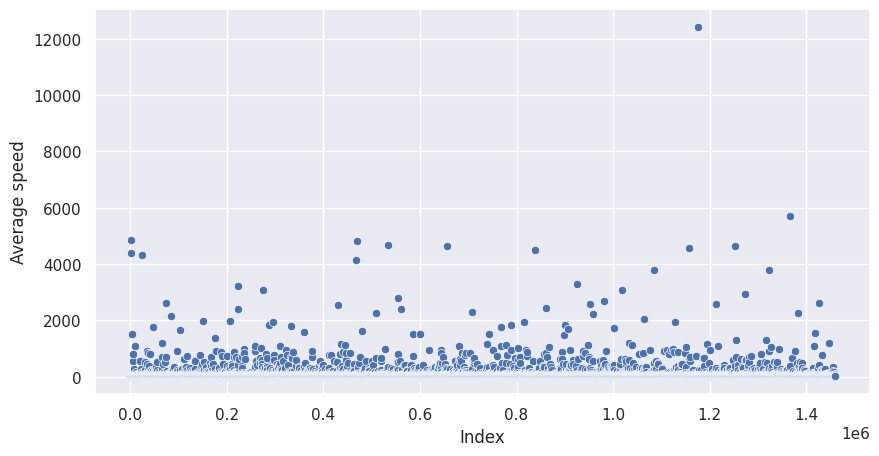

In [204]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [205]:
# Идентификация и удаление поездок, длительность которых превышает 24 часа
over_day_trips = taxi_data[taxi_data['trip_duration'] > 24*60*60]
print(f"Количество поездок, превышающих 24 часа: {over_day_trips.shape[0]}")
taxi_data.drop(over_day_trips.index, inplace=True)

# Идентификация и удаление поездок со скоростью выше 300 км/ч
excessive_speed_trips = taxi_data[taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 > 300]
print(f"Количество поездок со скоростью выше 300 км/ч: {excessive_speed_trips.shape[0]}")
taxi_data.drop(excessive_speed_trips.index, inplace=True)

Количество поездок, превышающих 24 часа: 4
Количество поездок со скоростью выше 300 км/ч: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [206]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

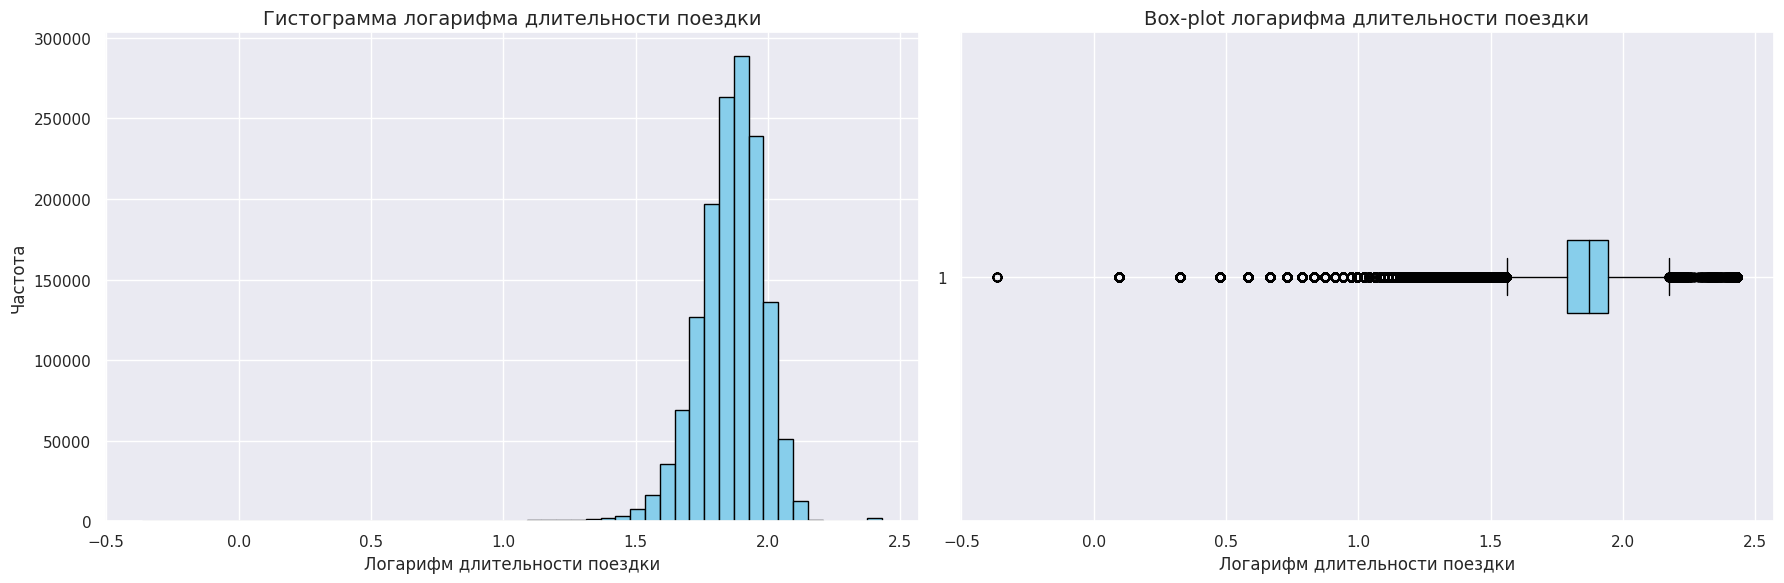

p-value (округленное до двух знаков после запятой): 0.00
При уровне значимости меньше 0.05 можно сделать вывод о том, что данные не имеют нормального распределения.


In [207]:
# Визуализация распределения длительности поездки в логарифмическом масштабе
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Гистограмма
ax[0].hist(np.log(taxi_data['trip_duration_log']), bins=50, color='skyblue', edgecolor='black')
ax[0].set_title('Гистограмма логарифма длительности поездки', fontsize=14)
ax[0].set_xlabel('Логарифм длительности поездки', fontsize=12)
ax[0].set_ylabel('Частота', fontsize=12)

# Коробчатая диаграмма
ax[1].boxplot(np.log(taxi_data['trip_duration_log']), vert=False, patch_artist=True,
              boxprops=dict(facecolor='skyblue', color='black'),
              capprops=dict(color='black'),
              whiskerprops=dict(color='black'),
              flierprops=dict(color='black', markeredgecolor='black'),
              medianprops=dict(color='black'))
ax[1].set_title('Box-plot логарифма длительности поездки', fontsize=14)
ax[1].set_xlabel('Логарифм длительности поездки', fontsize=12)

plt.tight_layout()
plt.show()

# Проверка на нормальность распределения с использованием теста Д’Агостино-Пирсона
log_trip_duration = np.log(taxi_data['trip_duration_log'])
stat, p_val = stats.normaltest(log_trip_duration)
print(f"p-value (округленное до двух знаков после запятой): {p_val:.2f}")

# уровень значимости
alpha = 0.05

if p_val < alpha:
    print(f"При уровне значимости меньше {alpha} можно сделать вывод о том, что данные не имеют нормального распределения.")
else:
    print(f"При уровне значимости больше {alpha} нельзя отвергнуть гипотезу о нормальном распределении данных.")

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

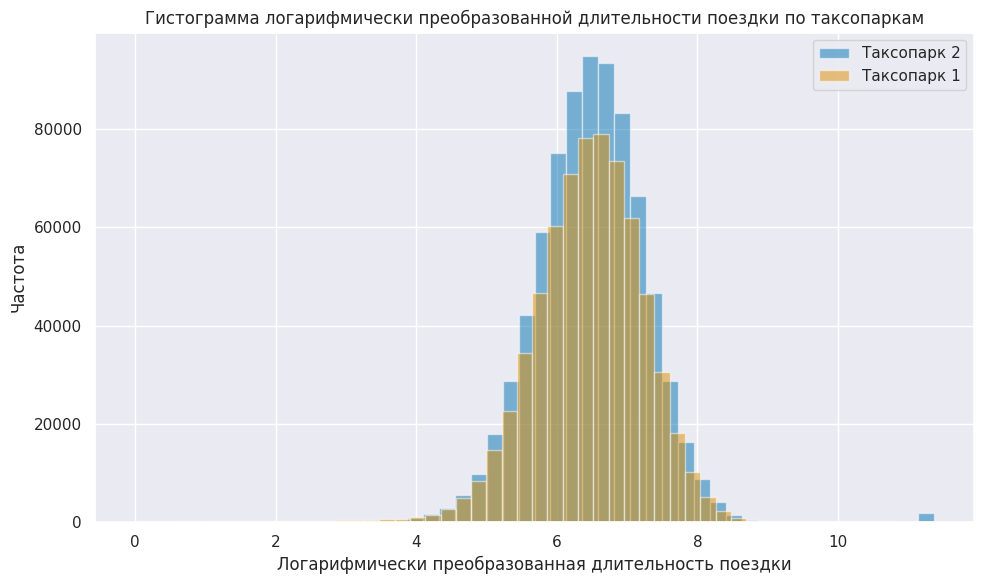

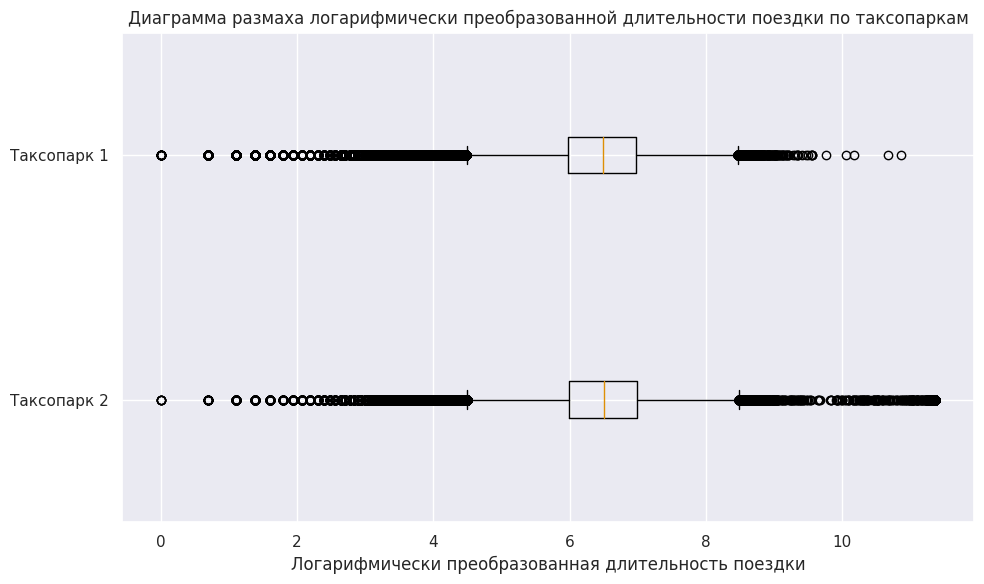

In [208]:
# Установка стиля графика
sns.set_palette('colorblind')

# Инициализация объекта для рисования графиков
fig, ax = plt.subplots(figsize=(10, 6))

# Построение гистограммы длительности поездок для каждого таксопарка
for vendor in taxi_data['vendor_id'].unique():
    duration_data = np.log(taxi_data[taxi_data['vendor_id'] == vendor]['trip_duration'])
    ax.hist(duration_data, bins=50, alpha=0.5, label=f'Таксопарк {vendor}')
ax.set_xlabel('Логарифмически преобразованная длительность поездки')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма логарифмически преобразованной длительности поездки по таксопаркам')
ax.legend()

# Отображение графика
plt.tight_layout()
plt.show()

# Инициализация объекта для рисования графиков
fig, ax = plt.subplots(figsize=(10, 6))

# Сбор данных для каждого таксопарка
box_data = []
box_labels = []
for vendor in taxi_data['vendor_id'].unique():
    box_data.append(np.log(taxi_data[taxi_data['vendor_id'] == vendor]['trip_duration']))
    box_labels.append(f'Таксопарк {vendor}')

# Построение коробчатой диаграммы длительности поездок для каждого таксопарка
ax.boxplot(box_data, vert=False, labels=box_labels)
ax.set_xlabel('Логарифмически преобразованная длительность поездки')
ax.set_title('Диаграмма размаха логарифмически преобразованной длительности поездки по таксопаркам')

# Отображение графика
plt.tight_layout()
plt.show()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

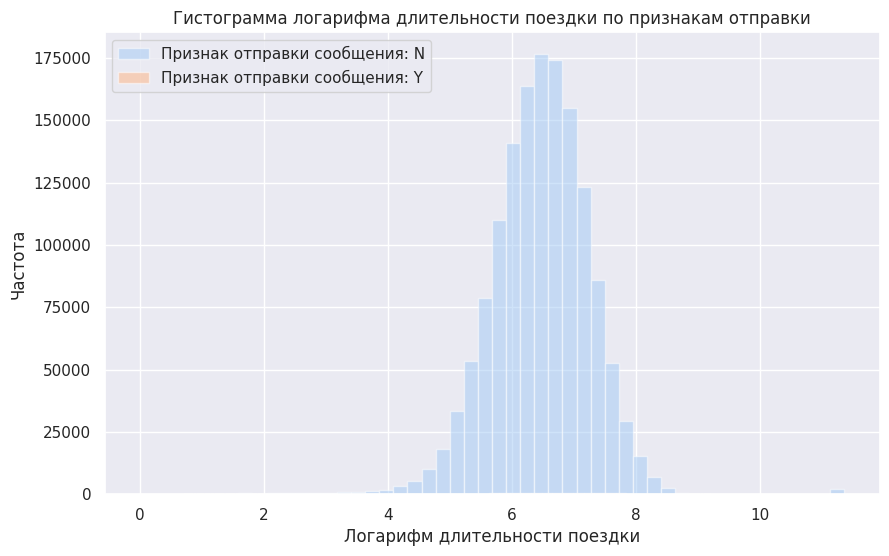

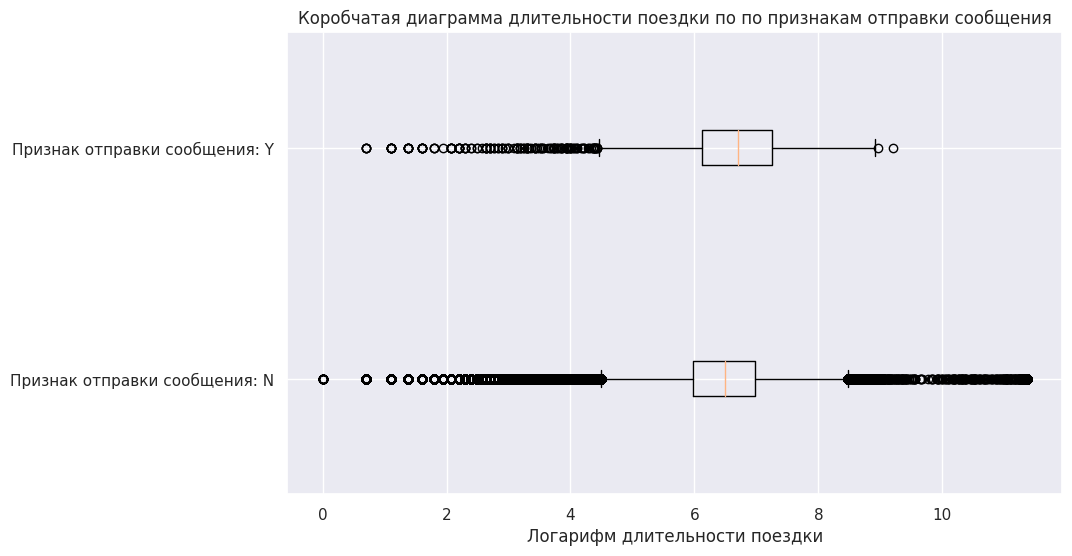

In [209]:
# Установка стиля и цветовой палитры
sns.set(style="darkgrid", palette="pastel")

# Создание гистограммы в логарифмическом масштабе для каждого признака отправки сообщения
plt.figure(figsize=(10, 6))
for flag in taxi_data['store_and_fwd_flag'].unique():
    data = np.log(taxi_data[taxi_data['store_and_fwd_flag'] == flag]['trip_duration'])
    plt.hist(data, bins=50, alpha=0.5, label=f'Признак отправки сообщения: {flag}')
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Частота')
plt.title('Гистограмма логарифма длительности поездки по признакам отправки')
plt.legend()
plt.show()

# Создание коробчатой диаграммы в логарифмическом масштабе для каждого признака отправки сообщения
plt.figure(figsize=(10, 6))
data = []
labels = []
for flag in taxi_data['store_and_fwd_flag'].unique():
    data.append(np.log(taxi_data[taxi_data['store_and_fwd_flag'] == flag]['trip_duration']))
    labels.append(f'Признак отправки сообщения: {flag}')
plt.boxplot(data, vert=False, labels=labels)
plt.xlabel('Логарифм длительности поездки')
plt.title('Коробчатая диаграмма длительности поездки по по признакам отправки сообщения')
plt.show()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

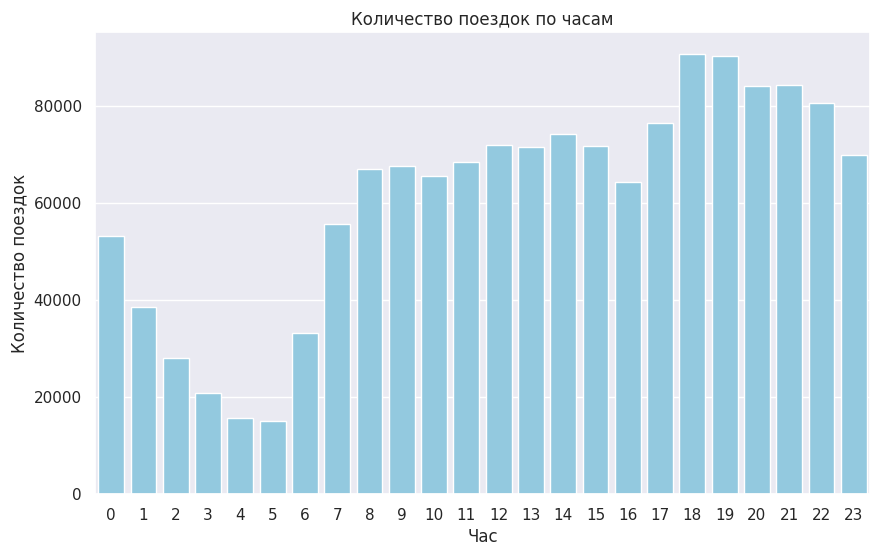

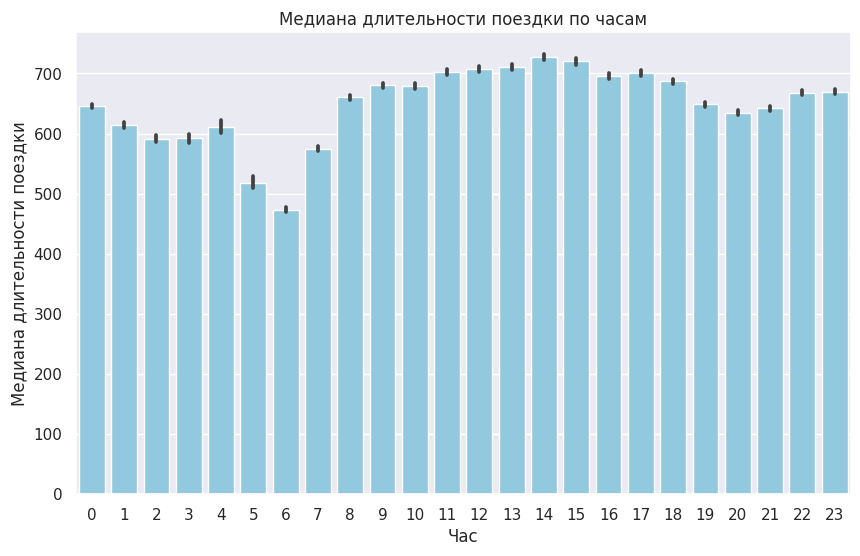

Реже всего такси заказывают в 5 часов.
Пик медианной длительности поездок наблюдается в 14 часов.


In [210]:
# Установка стиля и цветовой палитры
sns.set(style="darkgrid", palette="muted")

# Распределение количества поездок в зависимости от часа дня
plt.figure(figsize=(10, 6))
sns.countplot(data=taxi_data, x='pickup_hour', color='skyblue')
plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.title('Количество поездок по часам')
plt.show()

# Зависимость медианной длительности поездки от часа дня
plt.figure(figsize=(10, 6))
sns.barplot(data=taxi_data, x='pickup_hour', y='trip_duration', estimator=np.median, color='skyblue')
plt.xlabel('Час')
plt.ylabel('Медиана длительности поездки')
plt.title('Медиана длительности поездки по часам')
plt.show()

# Для вопроса а)
min_hour = taxi_data.groupby('pickup_hour').size().idxmin()
print(f"Реже всего такси заказывают в {min_hour} часов.")

# Для вопроса б)
peak_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median().idxmax()
print(f"Пик медианной длительности поездок наблюдается в {peak_hour} часов.")

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


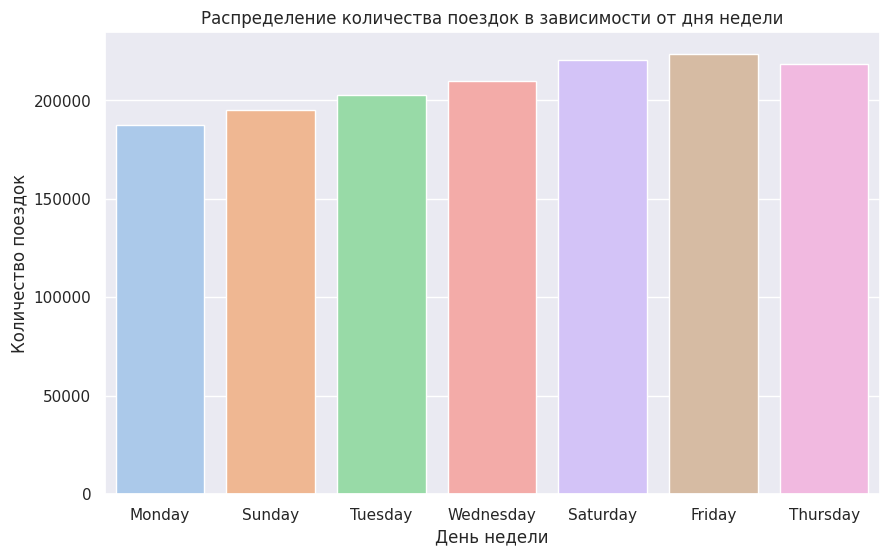

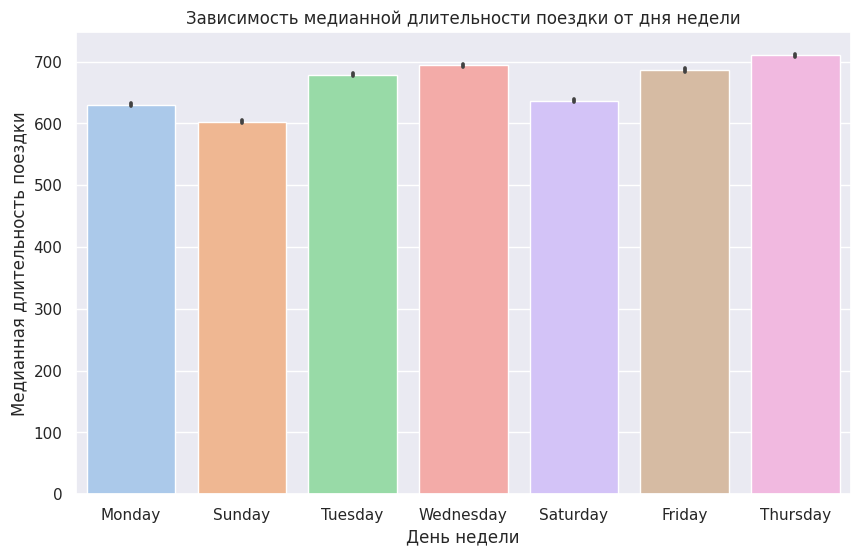

Больше всего поездок совершается в: Пятница.
Наименьшая медианная длительность поездок наблюдается в: Воскресенье.


In [211]:
# Установка стиля и цветовой палитры
sns.set(style="darkgrid", palette="pastel")

# Распределение количества поездок в зависимости от дня недели
plt.figure(figsize=(10, 6))
sns.countplot(data=taxi_data, x='pickup_day_of_week')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.title('Распределение количества поездок в зависимости от дня недели')
plt.show()

# Зависимость медианной длительности поездки от дня недели
plt.figure(figsize=(10, 6))
sns.barplot(data=taxi_data, x='pickup_day_of_week', y='trip_duration', estimator=np.median)
plt.xlabel('День недели')
plt.ylabel('Медианная длительность поездки')
plt.title('Зависимость медианной длительности поездки от дня недели')
plt.show()

# Для вопроса а)
most_trips_day = taxi_data.groupby('pickup_day_of_week').size().idxmax()

# Для вопроса б)
shortest_duration_day = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median().idxmin()

# Перевод английских названий дней недели в русский формат
day_of_week_dict = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}

print(f"Больше всего поездок совершается в: {day_of_week_dict[most_trips_day]}.")

print(f"Наименьшая медианная длительность поездок наблюдается в: {day_of_week_dict[shortest_duration_day]}.")


### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

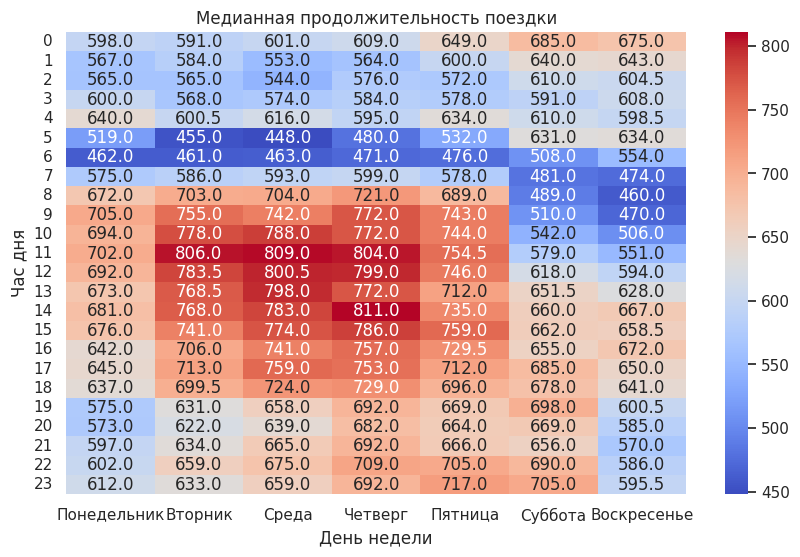

In [212]:
# Создание сводной таблицы
pivot_table = taxi_data.pivot_table(values='trip_duration', index='pickup_hour', columns='pickup_day_of_week', aggfunc='median')

# Определение порядка дней недели
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Переупорядочивание столбцов сводной таблицы
pivot_table = pivot_table.reindex(columns=day_order)

# Перевод английских названий дней недели в русский формат
day_of_week_dict = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник',
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'
}

# Перевод названий столбцов на русский язык
pivot_table.rename(columns=day_of_week_dict, inplace=True)

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(data=pivot_table, cmap='coolwarm', annot=True, fmt=".1f")
plt.xlabel('День недели')
plt.ylabel('Час дня')
plt.title('Медианная продолжительность поездки')
plt.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


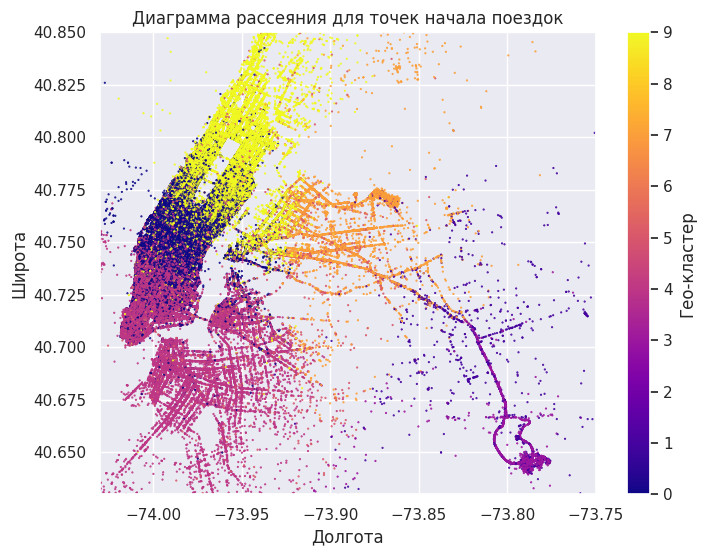

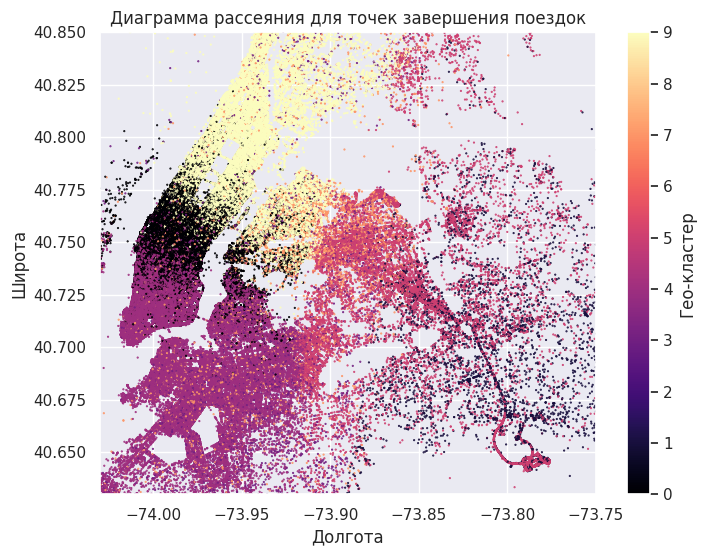

In [213]:
# Ограничения границ Нью-Йорка
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Размер точек
point_size = 0.3

# Диаграмма рассеяния для точек начала поездок
plt.figure(figsize=(8, 6))
plt.scatter(taxi_data['pickup_longitude'], taxi_data['pickup_latitude'], c=taxi_data['geo_cluster'], cmap='plasma', s=point_size)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('Диаграмма рассеяния для точек начала поездок')
plt.colorbar(label='Гео-кластер')
plt.show()

# Диаграмма рассеяния для точек завершения поездок
plt.figure(figsize=(8, 6))
plt.scatter(taxi_data['dropoff_longitude'], taxi_data['dropoff_latitude'], c=taxi_data['geo_cluster'], cmap='magma', s=point_size)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.title('Диаграмма рассеяния для точек завершения поездок')
plt.colorbar(label='Гео-кластер')
plt.show()


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [214]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [215]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [216]:
# Удаление признаков 'id' и 'dropoff_datetime'
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)
print(f"Осталось столбцов в таблице: {train_data.shape[1]}")

Осталось столбцов в таблице: 25


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [217]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Размерность данных:  {}'.format(train_data.shape))

Размерность данных:  (1458233, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [218]:
# Кодирование признака 'vendor_id'
# Если идентификатор таксопарка равен 1, присваиваем 0, в противном случае 1
train_data['vendor_id'] = train_data['vendor_id'].map({1: 0, 2: 1})

# Кодирование признака 'store_and_fwd_flag'
# Если флаг выставлен в значение "N", присваиваем 0, в противном случае 1
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

# Расчет среднего значения для закодированного столбца 'vendor_id'
mean_vendor_id = train_data['vendor_id'].mean()
# Округление до сотых и вывод результата
print(f"Среднее значение для закодированного столбца 'vendor_id': {mean_vendor_id:.2f}")

# Расчет среднего значения для закодированного столбца 'store_and_fwd_flag'
mean_store_and_fwd_flag = train_data['store_and_fwd_flag'].mean()
# Округление до тысячных и вывод результата
print(f"Среднее значение для закодированного столбца 'store_and_fwd_flag': {mean_store_and_fwd_flag:.3f}")

Среднее значение для закодированного столбца 'vendor_id': 0.53
Среднее значение для закодированного столбца 'store_and_fwd_flag': 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [219]:
# Определение столбцов с категориальными признаками
categorical_columns = ['pickup_day_of_week', 'geo_cluster', 'events']

# Инициализация объекта OneHotEncoder
# Параметр drop='first' используется для предотвращения мультиколлинеарности
one_hot_encoder = preprocessing.OneHotEncoder(drop='first')

# Применение OneHotEncoder к категориальным столбцам
# Метод .toarray() используется для преобразования разреженной матрицы в нормальный массив numpy
data_onehot_encoded = one_hot_encoder.fit_transform(train_data[categorical_columns]).toarray()

# Получение имен столбцов после OneHot-кодирования
column_names = one_hot_encoder.get_feature_names_out(categorical_columns)

# Создание нового DataFrame с закодированными столбцами
data_onehot = pd.DataFrame(data_onehot_encoded, columns=column_names)

# Получение количества бинарных столбцов в DataFrame после OneHot-кодирования
num_binary_columns = data_onehot.shape[1]

# Вывод количества бинарных столбцов
print(f"Количество бинарных столбцов после OneHot-кодирования: {num_binary_columns}")

Количество бинарных столбцов после OneHot-кодирования: 18


Добавим полученную таблицу с закодированными признаками:

In [220]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [221]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [222]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [223]:
# Создание объекта SelectKBest и применение отбора признаков на обучающей выборке
selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=25)
selector.fit(X_train, y_train_log)

# Получение индексов отобранных признаков
selected_feature_indices = selector.get_support(indices=True)

# Получение имен отобранных признаков
selected_feature_names = X_train.columns[selected_feature_indices]

# Вывод имен отобранных признаков
print("Отобранные признаки: ")
for feature in selected_feature_names:
    print(feature)

# Оставляем в обучающей и валидационной выборках только отобранные признаки
X_train = X_train[selected_feature_names]
X_valid = X_valid[selected_feature_names]

Отобранные признаки: 
vendor_id
passenger_count
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude
store_and_fwd_flag
pickup_hour
pickup_holiday
total_distance
total_travel_time
number_of_steps
haversine_distance
temperature
pickup_day_of_week_Monday
pickup_day_of_week_Saturday
pickup_day_of_week_Sunday
pickup_day_of_week_Thursday
pickup_day_of_week_Tuesday
pickup_day_of_week_Wednesday
geo_cluster_1
geo_cluster_3
geo_cluster_5
geo_cluster_7
geo_cluster_9


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [224]:
# Создаем экземпляр класса MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# Обучаем нормализатор на обучающей выборке и преобразуем данные
X_train_scaled = scaler.fit_transform(X_train)

# Преобразуем данные валидационной выборки
X_valid_scaled = scaler.transform(X_valid)

# Вычисляем среднее первого признака из валидационной выборки
first_feature_mean = np.mean(X_valid_scaled[:, 0])

# Округляем результат до сотых
first_feature_mean_rounded = round(first_feature_mean, 2)

print(f"Среднее значение первого признака в валидационной выборке: {first_feature_mean_rounded}")

# Преобразуем массивы в DataFrame для более удобной работы
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)

Среднее значение первого признака в валидационной выборке: 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [225]:
# Создание объекта модели Ridge регрессии
model = linear_model.Ridge(alpha=0.5)

# Обучение модели на обучающих данных
model.fit(X_train_scaled, y_train_log)

# Прогнозы на обучающих и валидационных данных
y_train_pred = model.predict(X_train_scaled)
y_valid_pred = model.predict(X_valid_scaled)

# Расчет метрики RMSLE на тренировочной и валидационной выборках
rmsle_train = np.sqrt(metrics.mean_squared_log_error(np.exp(y_train_log), np.exp(y_train_pred)))
rmsle_valid = np.sqrt(metrics.mean_squared_log_error(np.exp(y_valid_log), np.exp(y_valid_pred)))

# Округление значений метрики до сотых
rmsle_train = round(rmsle_train, 2)
rmsle_valid = round(rmsle_valid, 2)

# Вывод результатов
print("Метрика RMSLE на тренировочной выборке:", rmsle_train)
print("Метрика RMSLE на валидационной выборке:", rmsle_valid)

Метрика RMSLE на тренировочной выборке: 0.53
Метрика RMSLE на валидационной выборке: 0.53


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [226]:
# Генерация полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

# Обучение модели полиномиальной регрессии
poly_reg = linear_model.LinearRegression()
poly_reg.fit(X_train_poly, y_train_log)

# Предсказание на обучающей и валидационной выборках
y_train_pred = poly_reg.predict(X_train_poly)
y_valid_pred = poly_reg.predict(X_valid_poly)

# Расчет метрики RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_log_error(np.exp(y_train_log), np.exp(y_train_pred)))
rmsle_valid = np.sqrt(metrics.mean_squared_log_error(np.exp(y_valid_log), np.exp(y_valid_pred)))

# Округление до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

print("RMSLE на тренировочной выборке:", rmsle_train_rounded)
print("RMSLE на валидационной выборке:", rmsle_valid_rounded)

# Проверка на переобучение
if rmsle_train_rounded < rmsle_valid_rounded:
    print("Модель может быть переобучена, так как ошибка на обучающей выборке меньше ошибки на валидационной.")
else:
    print("Признаков переобучения не обнаружено.")

RMSLE на тренировочной выборке: 0.46
RMSLE на валидационной выборке: 0.49
Модель может быть переобучена, так как ошибка на обучающей выборке меньше ошибки на валидационной.


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [227]:
# Генерация полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

# Обучение модели полиномиальной регрессии с регуляризацией
ridge_reg = linear_model.Ridge(alpha=1)
ridge_reg.fit(X_train_poly, y_train_log)

# Предсказание на обучающей и валидационной выборках
y_train_pred = ridge_reg.predict(X_train_poly)
y_valid_pred = ridge_reg.predict(X_valid_poly)

# Расчет метрики RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_log_error(np.exp(y_train_log), np.exp(y_train_pred)))
rmsle_valid = np.sqrt(metrics.mean_squared_log_error(np.exp(y_valid_log), np.exp(y_valid_pred)))

# Округление до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

print("RMSLE на тренировочной выборке:", rmsle_train_rounded)
print("RMSLE на валидационной выборке:", rmsle_valid_rounded)

RMSLE на тренировочной выборке: 0.47
RMSLE на валидационной выборке: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [228]:
# Создание и обучение модели дерева решений
tree_reg = tree.DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_scaled, y_train_log)

# Предсказание на обучающей и валидационной выборках
y_train_pred = tree_reg.predict(X_train_scaled)
y_valid_pred = tree_reg.predict(X_valid_scaled)

# Расчет метрики RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_log_error(np.exp(y_train_log), np.exp(y_train_pred)))
rmsle_valid = np.sqrt(metrics.mean_squared_log_error(np.exp(y_valid_log), np.exp(y_valid_pred)))

# Округление до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

print("RMSLE на тренировочной выборке:", rmsle_train_rounded)
print("RMSLE на валидационной выборке:", rmsle_valid_rounded)

# Проверка на переобучение
if rmsle_train_rounded < rmsle_valid_rounded:
    print("Модель может быть переобучена, так как ошибка на обучающей выборке меньше ошибки на валидационной.")
else:
    print("Признаков переобучения не обнаружено.")

RMSLE на тренировочной выборке: 0.0
RMSLE на валидационной выборке: 0.56
Модель может быть переобучена, так как ошибка на обучающей выборке меньше ошибки на валидационной.


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


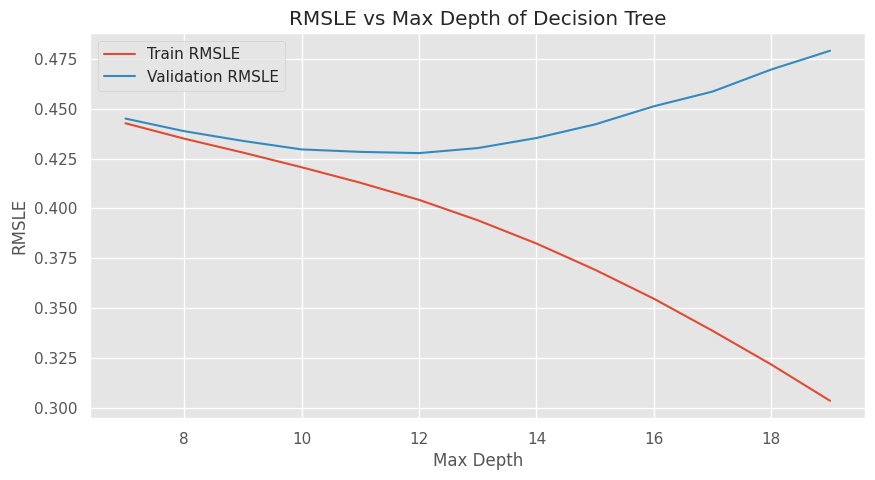

In [229]:
import matplotlib.pyplot as plt

max_depths = range(7, 20)
train_rmsle = []
valid_rmsle = []

for depth in max_depths:
    # Создание и обучение модели дерева решений
    tree_reg = tree.DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_reg.fit(X_train_scaled, y_train_log)

    # Предсказание на обучающей и валидационной выборках
    y_train_pred = tree_reg.predict(X_train_scaled)
    y_valid_pred = tree_reg.predict(X_valid_scaled)

    # Расчет метрики RMSLE
    rmsle_train = np.sqrt(metrics.mean_squared_log_error(np.exp(y_train_log), np.exp(y_train_pred)))
    rmsle_valid = np.sqrt(metrics.mean_squared_log_error(np.exp(y_valid_log), np.exp(y_valid_pred)))

    # Добавление значений метрик в списки
    train_rmsle.append(rmsle_train)
    valid_rmsle.append(rmsle_valid)

plt.style.use('ggplot')  # Определение стиля графика
plt.figure(figsize=(10, 5))  # Определение размера графика
# Построение линейных графиков
plt.plot(max_depths, train_rmsle, label='Train RMSLE')
plt.plot(max_depths, valid_rmsle, label='Validation RMSLE')
plt.xlabel('Max Depth')
plt.ylabel('RMSLE')
plt.title('RMSLE vs Max Depth of Decision Tree')
plt.legend()
plt.show()

In [230]:
# Задаём оптимальную глубину дерева решений, выбранную на предыдущем шаге
optimal_depth = 12

# Инициализируем и обучаем модель дерева решений с оптимальной глубиной
tree_reg_optimal = tree.DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
tree_reg_optimal.fit(X_train_scaled, y_train_log)

# Выполняем предсказания на обучающей и валидационной выборках
y_train_pred_optimal = tree_reg_optimal.predict(X_train_scaled)
y_valid_pred_optimal = tree_reg_optimal.predict(X_valid_scaled)

# Рассчитываем метрику RMSLE на обучающей и валидационной выборках
rmsle_train_optimal = np.sqrt(metrics.mean_squared_log_error(np.exp(y_train_log), np.exp(y_train_pred_optimal)))
rmsle_valid_optimal = np.sqrt(metrics.mean_squared_log_error(np.exp(y_valid_log), np.exp(y_valid_pred_optimal)))

# Округляем значения RMSLE до сотых
rmsle_train_optimal_rounded = round(rmsle_train_optimal, 2)
rmsle_valid_optimal_rounded = round(rmsle_valid_optimal, 2)

# Выводим результаты
print(f"RMSLE на тренировочной выборке: {rmsle_train_optimal_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_optimal_rounded}")


RMSLE на тренировочной выборке: 0.4
RMSLE на валидационной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [231]:
# Инициализация и обучение модели случайного леса
forest_reg = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True
)
forest_reg.fit(X_train_scaled, y_train_log)

# Предсказания на обучающей и валидационной выборках
y_train_pred_forest = forest_reg.predict(X_train_scaled)
y_valid_pred_forest = forest_reg.predict(X_valid_scaled)

# Расчет метрики RMSLE на обучающей и валидационной выборках
rmsle_train_forest = np.sqrt(metrics.mean_squared_log_error(np.exp(y_train_log), np.exp(y_train_pred_forest)))
rmsle_valid_forest = np.sqrt(metrics.mean_squared_log_error(np.exp(y_valid_log), np.exp(y_valid_pred_forest)))

# Округление значений RMSLE до сотых
rmsle_train_forest_rounded = round(rmsle_train_forest, 2)
rmsle_valid_forest_rounded = round(rmsle_valid_forest, 2)

# Вывод результатов
print(f"RMSLE на тренировочной выборке: {rmsle_train_forest_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_forest_rounded}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 27.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RMSLE на тренировочной выборке: 0.4
RMSLE на валидационной выборке: 0.41


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   12.2s finished


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [232]:
# Инициализация и обучение модели градиентного бустинга
gb_reg = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
)
gb_reg.fit(X_train_scaled, y_train_log)

# Предсказания на обучающей и валидационной выборках
y_train_pred_gb = gb_reg.predict(X_train_scaled)
y_valid_pred_gb = gb_reg.predict(X_valid_scaled)

# Расчет метрики RMSLE на обучающей и валидационной выборках
rmsle_train_gb = np.sqrt(metrics.mean_squared_log_error(np.exp(y_train_log), np.exp(y_train_pred_gb)))
rmsle_valid_gb = np.sqrt(metrics.mean_squared_log_error(np.exp(y_valid_log), np.exp(y_valid_pred_gb)))

# Округление значений RMSLE до сотых
rmsle_train_gb_rounded = round(rmsle_train_gb, 2)
rmsle_valid_gb_rounded = round(rmsle_valid_gb, 2)

# Вывод результатов
print(f"RMSLE на тренировочной выборке: {rmsle_train_gb_rounded}")
print(f"RMSLE на валидационной выборке: {rmsle_valid_gb_rounded}")

RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


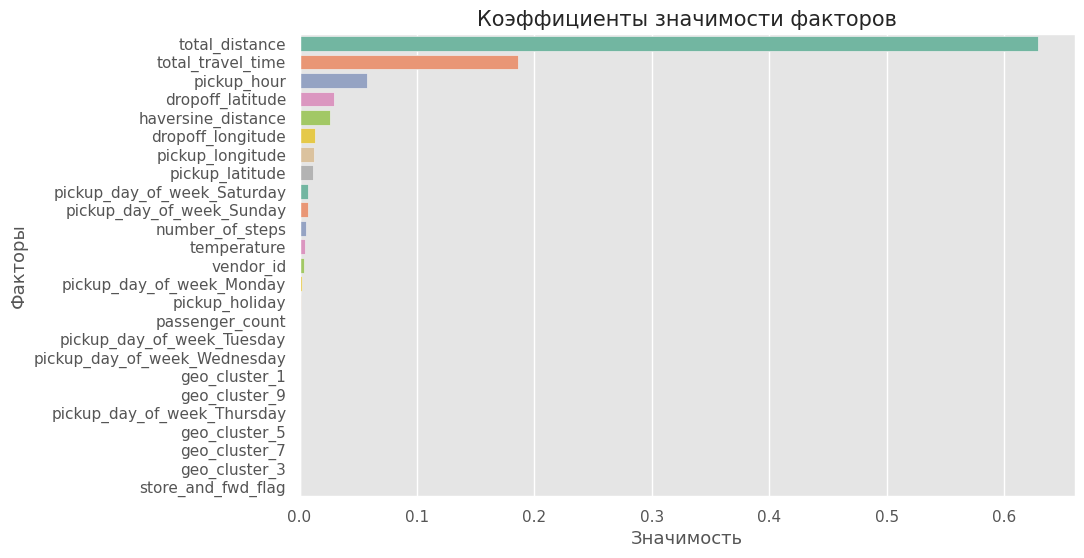

Топ-3 наиболее значимых фактора:
['total_distance', 'total_travel_time', 'pickup_hour']


In [233]:
# Получение значимости факторов из модели градиентного бустинга
feature_importance = gb_reg.feature_importances_

# Создание списка названий факторов
feature_names = X_train.columns.tolist()

# Создание DataFrame с названиями факторов и их значимостью
importance_df = pd.DataFrame({
    'feature': X_train.columns.tolist(),
    'importance': feature_importance
})

# Сортировка по значимости
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df, palette="Set2")
plt.xlabel('Значимость', fontsize=13)
plt.ylabel('Факторы', fontsize=13)
plt.title('Коэффициенты значимости факторов', fontsize=15)
plt.show()

# Вывод топ-3 наиболее значимых факторов
print("Топ-3 наиболее значимых фактора:")
print(importance_df['feature'].head(3).tolist())

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [234]:
# Обратное преобразование предсказаний и истинных значений из логарифмического масштаба
y_valid = np.exp(y_valid_log)
y_valid_pred_gb = np.exp(y_valid_pred_gb)

# Расчет медианной абсолютной ошибки
meae = metrics.median_absolute_error(y_valid, y_valid_pred_gb)

# Перевод значения метрики в минуты и округление
meae_minutes = round(meae / 60, 1)

# Вывод значения метрики
print(f"MeAE на валидационной выборке: {meae_minutes} минут")

MeAE на валидационной выборке: 1.8 минут


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [235]:
test_data = pd.read_csv("/content/gdrive/MyDrive/Practice/test_data.csv")
osrm_data_test = pd.read_csv("/content/gdrive/MyDrive/Practice/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [236]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(weather_data, test_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)
X_test = test_data[feature_names]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [237]:
# Предсказание длительности поездок для тестовой выборки
y_test_predict = gb_reg.predict(X_test_scaled)

# Обратное преобразование из логарифмического масштаба
y_test_predict = np.exp(y_test_predict)

# Создание DataFrame для submission-файла
submission_df = pd.DataFrame({
    'id': test_id,
    'trip_duration': y_test_predict
})

# Сохранение submission-файла в формате CSV
submission_df.to_csv('submission_practise.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [239]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


После чего модуль можно импортировать:

In [240]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [241]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=feature_names)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=feature_names)
dtest = xgb.DMatrix(X_test_scaled, feature_names=feature_names)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [242]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42222	valid-rmse:5.42195
[10]	train-rmse:1.93569	valid-rmse:1.93563
[20]	train-rmse:0.78551	valid-rmse:0.78635
[30]	train-rmse:0.47924	valid-rmse:0.48127
[40]	train-rmse:0.42057	valid-rmse:0.42325
[50]	train-rmse:0.40874	valid-rmse:0.41188
[60]	train-rmse:0.40423	valid-rmse:0.40773
[70]	train-rmse:0.40110	valid-rmse:0.40502
[80]	train-rmse:0.39888	valid-rmse:0.40310
[90]	train-rmse:0.39739	valid-rmse:0.40183
[100]	train-rmse:0.39571	valid-rmse:0.40040
[110]	train-rmse:0.39416	valid-rmse:0.39911
[120]	train-rmse:0.39324	valid-rmse:0.39856
[130]	train-rmse:0.39188	valid-rmse:0.39752
[140]	train-rmse:0.39080	valid-rmse:0.39677
[150]	train-rmse:0.38992	valid-rmse:0.39616
[160]	train-rmse:0.38925	valid-rmse:0.39570
[170]	train-rmse:0.38854	valid-rmse:0.39529
[180]	train-rmse:0.38793	valid-rmse:0.39500
[190]	train-rmse:0.38720	valid-rmse:0.39469
[200]	train-rmse:0.38608	valid-rmse:0.39387
[210]	train-rmse:0.38533	valid-rmse:0.39352
[220]	train-rmse:0.38464	valid-rmse:0.39326

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [243]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39107


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

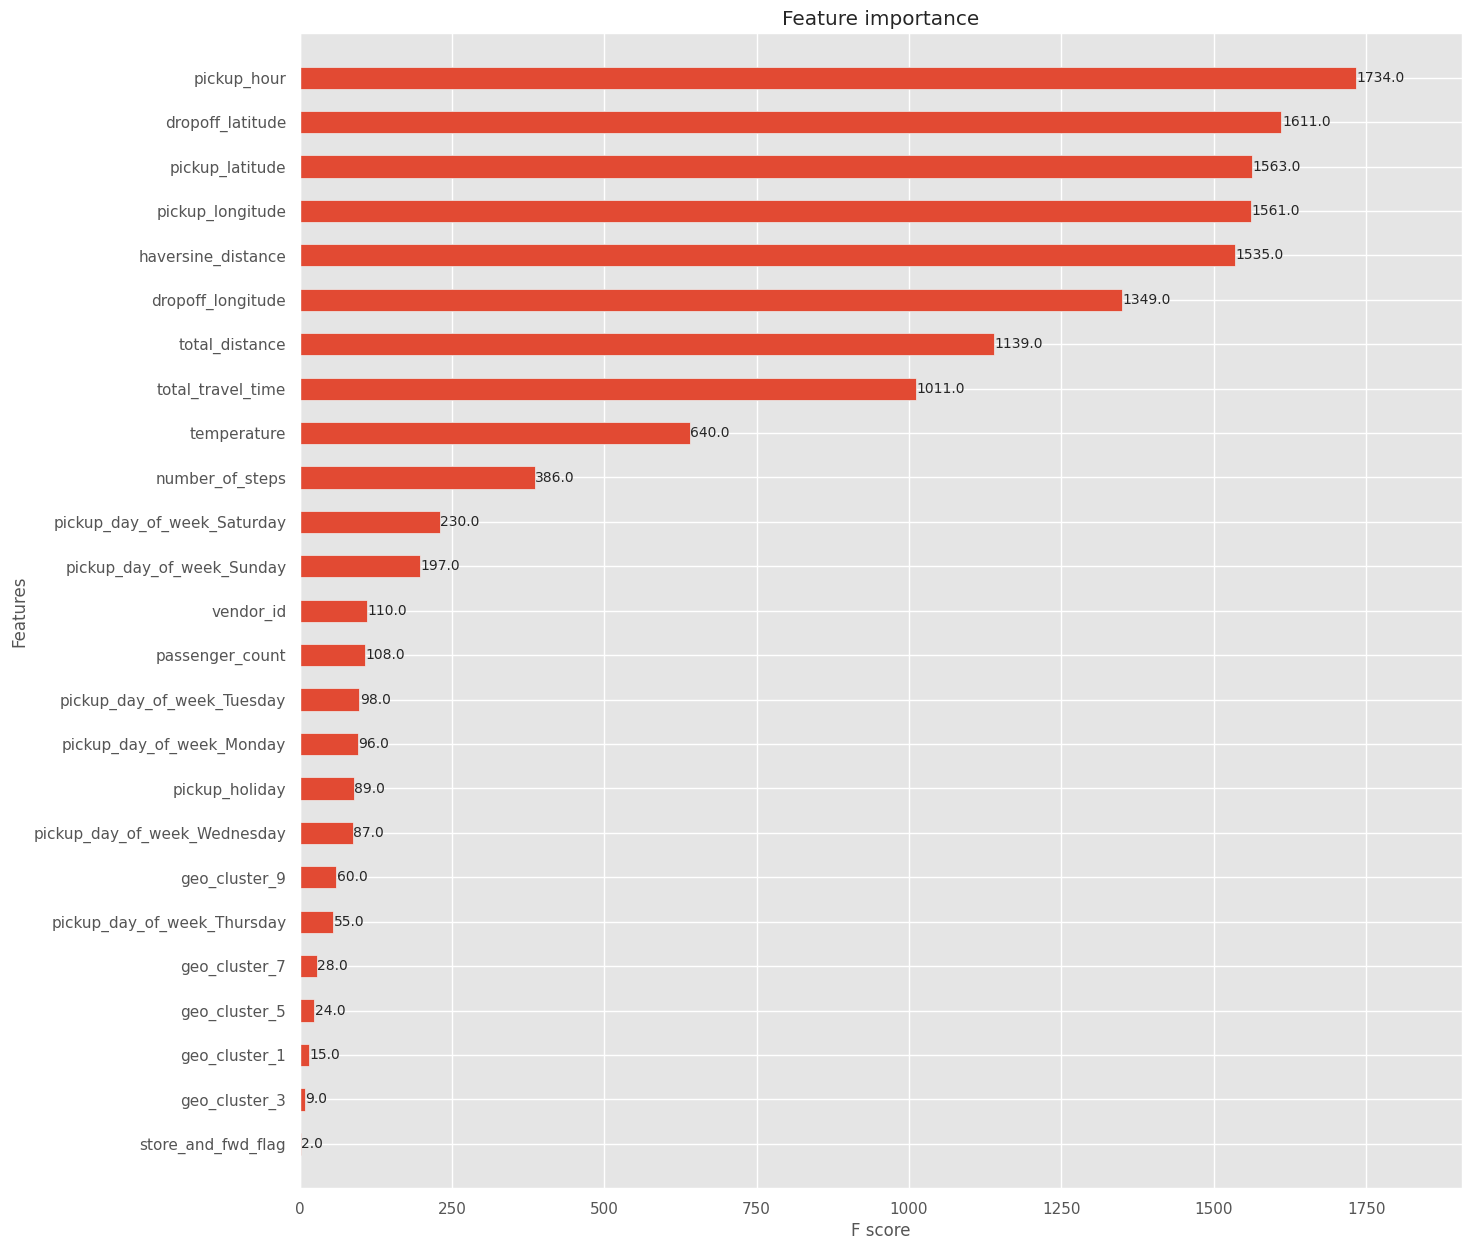

In [244]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)